In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import time

load the data

In [ ]:
data = pd.read_csv('./data/dataBig_300_0.csv')
print(len(data))
data.drop('Unnamed: 0', axis=1, inplace=True)

131703


inspect the data

In [48]:
print(data.columns)
print(data.head())

Index(['link', 'result', 'white_elo', 'black_elo', 'white_rating_diff',
       'black_rating_diff', 'eco', 'opening', 'time_control', 'termination',
       'white_cpl', 'black_cpl', 'white_moves', 'black_moves',
       'white_inaccuracies', 'white_mistakes', 'white_blunders',
       'black_inaccuracies', 'black_mistakes', 'black_blunders'],
      dtype='object')
                           link   result  white_elo  black_elo  \
0  https://lichess.org/T24w2sjS      1-0       1820       1898   
1  https://lichess.org/667k2igw  1/2-1/2       1580       1546   
2  https://lichess.org/X26rBn5w      0-1       1760       1746   
3  https://lichess.org/GbzwEMP9      1-0       1370       1375   
4  https://lichess.org/XOVSAmbl      1-0       1833       1419   

   white_rating_diff  black_rating_diff  eco  \
0              174.0               -5.0  D10   
1                0.0                1.0  C50   
2               -6.0                5.0  B90   
3                6.0               -6.0  C62  

In [49]:
# compute the averages for the sake of avoiding the curse of dimensionality 
data['avg_white_cpl'] = data["white_cpl"]/data["white_moves"]
data['avg_black_cpl'] = data["black_cpl"]/data["black_moves"]
data['avg_white_mistakes'] = data["white_mistakes"]/data["white_moves"]
data['avg_black_mistakes'] = data["black_mistakes"]/data["black_moves"]
data['avg_white_blunders'] = data["white_blunders"]/data["white_moves"]
data['avg_black_blunders'] = data["black_blunders"]/data["black_moves"]
data['avg_white_inaccuracies'] = data["white_inaccuracies"]/data["white_moves"]
data['avg_black_inaccuracies'] = data["black_inaccuracies"]/data["black_moves"]

In [50]:
data.dtypes

link                       object
result                     object
white_elo                   int64
black_elo                   int64
white_rating_diff         float64
black_rating_diff         float64
eco                        object
opening                    object
time_control               object
termination                object
white_cpl                   int64
black_cpl                   int64
white_moves                 int64
black_moves                 int64
white_inaccuracies          int64
white_mistakes              int64
white_blunders              int64
black_inaccuracies          int64
black_mistakes              int64
black_blunders              int64
avg_white_cpl             float64
avg_black_cpl             float64
avg_white_mistakes        float64
avg_black_mistakes        float64
avg_white_blunders        float64
avg_black_blunders        float64
avg_white_inaccuracies    float64
avg_black_inaccuracies    float64
dtype: object

In [51]:
X = data[['avg_white_cpl', 'avg_black_cpl', 'avg_white_mistakes', 'avg_black_mistakes', 'avg_white_blunders', 'avg_black_blunders', 'avg_white_inaccuracies', 'avg_black_inaccuracies', 'white_moves']]
ohe = pd.get_dummies(data[['time_control', 'termination', 'result']], drop_first=True) # one hot encode the categorical variables
scaler = StandardScaler() # Standardize the data
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
y = data['white_elo']
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2) # split the data into training and testing sets

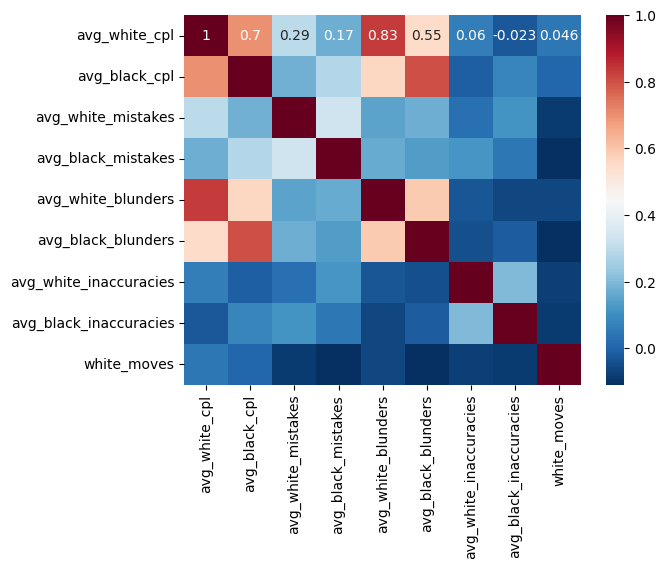

In [52]:
corr_matrix = x_train.corr(method='pearson')  # 'pearson' is default

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()


In [53]:
print(X.columns)

Index(['avg_white_cpl', 'avg_black_cpl', 'avg_white_mistakes',
       'avg_black_mistakes', 'avg_white_blunders', 'avg_black_blunders',
       'avg_white_inaccuracies', 'avg_black_inaccuracies', 'white_moves'],
      dtype='object')


Initialize and fit KNN regressor model on the training data

In [54]:
regressor = KNeighborsRegressor(n_neighbors = 100, weights = 'distance')
regressor.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=100, weights='distance')

In [55]:
y_pred = regressor.predict(x_test)
print(regressor.score(x_test, y_test))

0.2125218188824013


In [56]:
print("MSE:", np.mean(np.sqrt((y_test-y_pred)**2)))
print("MAD:", mean_absolute_error(y_test, y_pred))

MSE: 293.6566492154978
293.6566492154978


Let's add OHE columns to our data and see if it improves the score.

In [57]:
print(ohe.columns)

Index(['termination_Rules infraction', 'termination_Time forfeit',
       'result_1-0', 'result_1/2-1/2'],
      dtype='object')


In [58]:
X = X.join(ohe, lsuffix='_left', rsuffix='_right')
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)

In [59]:
correlation_df = X.join(data['white_elo']) # add white_elo to the correlation matrix, to see how it correlates with the other variables

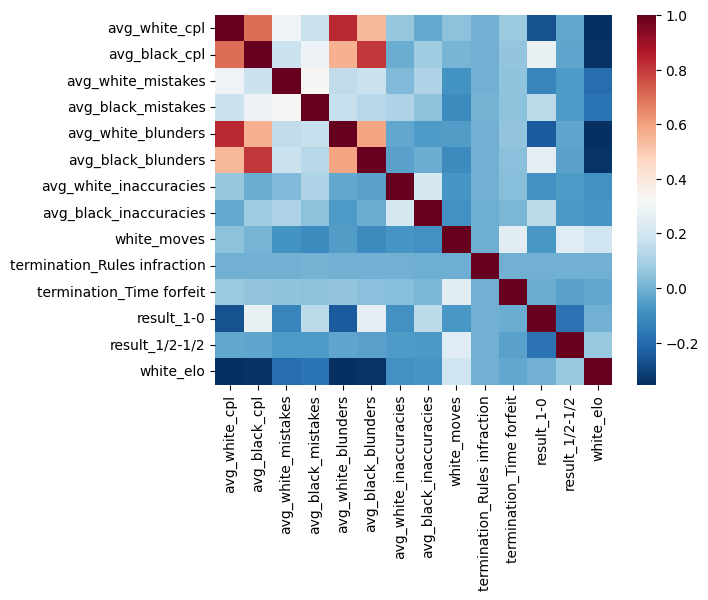

In [60]:
corr_matrix = correlation_df.corr(method='pearson')  # 'pearson' is the default setting. 

sns.heatmap(corr_matrix, annot=False, cmap='RdBu_r')
plt.show()

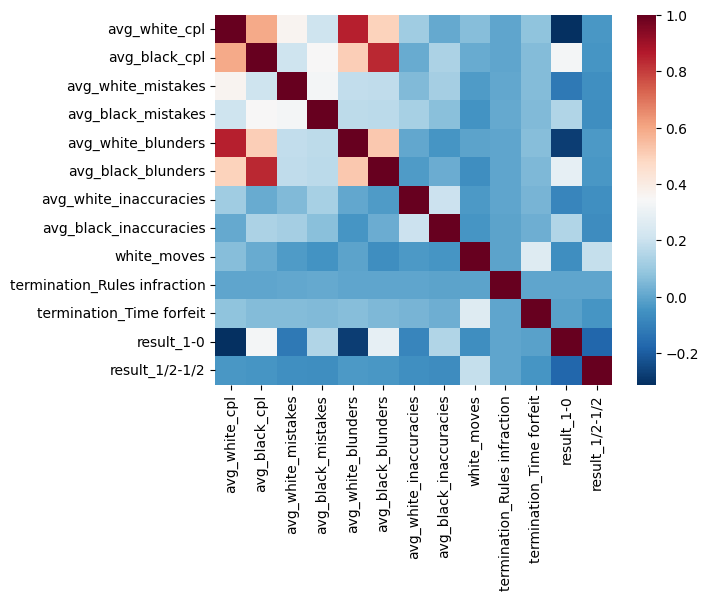

In [61]:
corr_matrix = x_train.corr(method='spearman')  # spearman method

sns.heatmap(corr_matrix, annot=False, cmap='RdBu_r')
plt.show()

data cleaning

In [62]:
correlation_df.drop(['termination_Rules infraction', 'termination_Time forfeit', 'avg_white_inaccuracies', 'avg_black_inaccuracies'], axis=1, inplace=True)

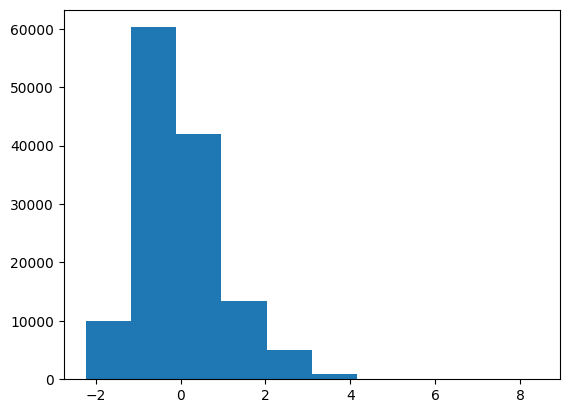

In [63]:
plt.hist(correlation_df['white_moves'])
plt.show()

In [64]:
correlation_df = correlation_df[(correlation_df["white_moves"] > correlation_df['white_moves'].quantile(q=.15)) & (correlation_df["white_moves"] < correlation_df["white_moves"].quantile(q=.85))]

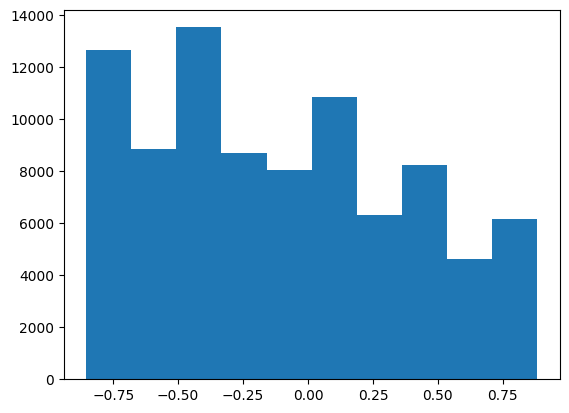

In [65]:
plt.hist(correlation_df['white_moves'])
plt.show()

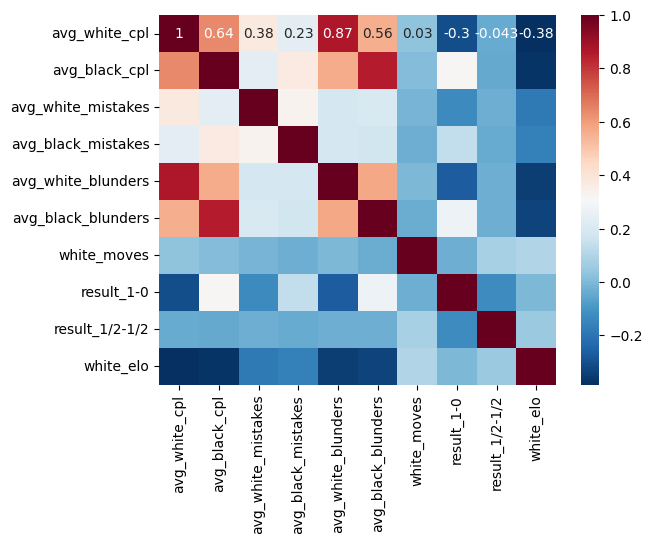

In [66]:
corr_matrix = correlation_df.corr(method='spearman')  # 'pearson' is default

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()

Now we will use the grid search technique for the purpose of finding the best number of neighbours.

In [68]:
knn = KNeighborsRegressor()
params = {'n_neighbors': [int(x) for x in np.logspace(1,3,num=3)]}
model = GridSearchCV(knn, param_grid=params, cv=5)
model.fit(correlation_df.drop('white_elo', axis=1, inplace=False), correlation_df["white_elo"])
model.best_params_

{'n_neighbors': 100}

In [69]:
y_pred = model.predict(correlation_df.drop('white_elo', axis=1, inplace=False))

In [70]:
print(mean_absolute_error(y_pred, correlation_df["white_elo"]))

289.0943696494958


In [71]:
print([int(x) for x in np.logspace(1,4,num=10)])

[10, 21, 46, 100, 215, 464, 1000, 2154, 4641, 10000]


In [ ]:
mad_list = []
for neigh in [int(x) for x in np.linspace(50,150,num=10)]:
    start = time.time()
    print('current n:', neigh)
    knn = KNeighborsRegressor(n_neighbors=neigh, weights='distance')
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    mad = mean_absolute_error(y_test, y_pred)
    mad_list.append(mad)
    end = time.time()
    print("MAD:", mad)
    print(f"time taken for n={neigh}: {end-start}")

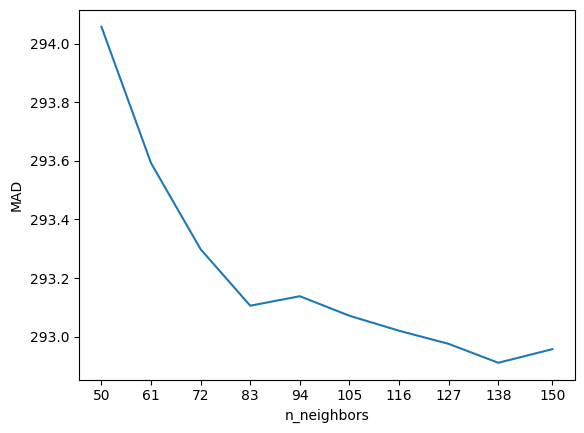

In [78]:
neigh = [int(x) for x in np.linspace(50,150,num=10)]
plt.plot(neigh, mad_list)
plt.xticks(neigh)
plt.xlabel("n_neighbors")
plt.ylabel("MAD")
plt.show()

In [ ]:
mse_list = []
for neigh in [int(x) for x in np.linspace(50,150,num=10)]:
    start = time.time()
    print('current n:', neigh)
    knn = KNeighborsRegressor(n_neighbors=neigh, weights='distance')
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)
    end = time.time()
    print("MSE:", mse)
    print(f"time taken for n={neigh}: {end-start}")

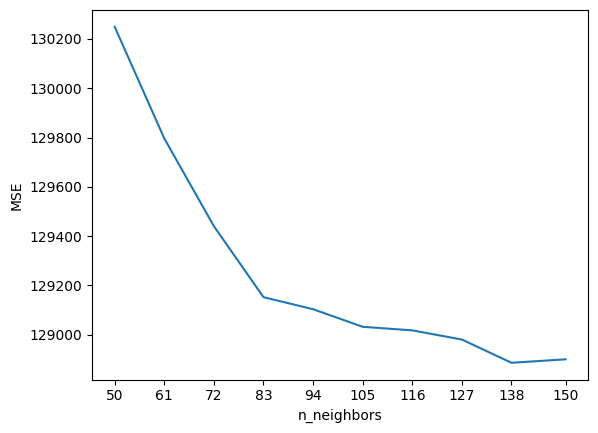

In [87]:
neigh = [int(x) for x in np.linspace(50,150,num=10)]
plt.plot(neigh, mse_list)
plt.xticks(neigh)
plt.xlabel("n_neighbors")
plt.ylabel("MSE")
plt.show()

Conclusion: we need to choose such a parameter that it provides relatively low MAD and MSE, while not being too large, as we don't want to overfit the model.

In [80]:
knn = KNeighborsRegressor()
params = {'n_neighbors': [int(x) for x in np.linspace(60,90,num=30)]}
model = GridSearchCV(knn, param_grid=params, cv=5)
model.fit(x_train,y_train)
model.best_params_

{'n_neighbors': 90}

In [83]:
best_knn = KNeighborsRegressor(n_neighbors = 90, weights = 'distance')
best_knn.fit(x_train, y_train)
y_pred = best_knn.predict(x_test)
print(best_knn.score(x_test, y_test))
print("MSE:", np.mean(np.sqrt((y_test-y_pred)**2)))
print("MAD:", mean_absolute_error(y_test, y_pred))

0.21615218842549677
MSE: 293.09990797384364
MAD: 293.09990797384364


We managed to obtain 293 on both MSE and MAD metrics. 